In [1]:
from pyspark.sql import SQLContext
from pyspark.sql import functions as sf
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import DateType
from datetime import date, timedelta
import datetime as dt
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor
from pyspark.sql.functions import col, avg, sum
import numpy as np
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
import pandas as pd
import pyspark

In [2]:
log4jLogger = sc._jvm.org.apache.log4j
LOGGER = log4jLogger.LogManager.getLogger(__name__)
LOGGER.error("pyspark script logger initialized")

In [3]:
sc.stop()
sc = pyspark.SparkContext(master="spark://172.16.27.208:7077",appName="spark")
sc

<SparkContext master=spark://172.16.27.208:7077 appName=spark>

In [4]:
base_path = "/home/test5/Desktop/smart-meters-in-london/"
sqlcontext = SQLContext(sc)

In [5]:
cluster_feature = sqlcontext.read.csv(path=base_path+"bk=8_means_Feature.csv",header=True,inferSchema=True)
# cluster_feature = cluster_feature.drop("_c0","date2")
# cluster_feature = cluster_feature.withColumn("windSpeed",cluster_feature["windSpeed"].cast("float"))
# cluster_feature = cluster_feature.withColumn("dewPoint",cluster_feature["dewPoint"].cast("float"))
cluster_feature.printSchema()
type(cluster_feature)

root
 |-- _c0: integer (nullable = true)
 |-- cluster_id: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- hour: integer (nullable = true)
 |-- energy(kWh/h): double (nullable = true)
 |-- month: integer (nullable = true)
 |-- weekDay: string (nullable = true)
 |-- 1_diff_energy_t_0: double (nullable = true)
 |-- 2_diff_energy_t_0: double (nullable = true)
 |-- 3_diff_energy_t_0: double (nullable = true)
 |-- 4_diff_energy_t_0: double (nullable = true)
 |-- 5_diff_energy_t_0: double (nullable = true)
 |-- 6_diff_energy_t_0: double (nullable = true)
 |-- 7_diff_energy_t_0: double (nullable = true)
 |-- 1_diff_energy_t_1: double (nullable = true)
 |-- 2_diff_energy_t_1: double (nullable = true)
 |-- 3_diff_energy_t_1: double (nullable = true)
 |-- 4_diff_energy_t_1: double (nullable = true)
 |-- 5_diff_energy_t_1: double (nullable = true)
 |-- 6_diff_energy_t_1: double (nullable = true)
 |-- 7_diff_energy_t_1: double (nullable = true)
 |-- 1_diff_energy_t_2: double (

pyspark.sql.dataframe.DataFrame

In [6]:
cluster_feature = cluster_feature.withColumn("holiday1",sf.when((col("Weekday/end")==1) | (col("holiday")==1),1).otherwise(0))
cluster_feature = cluster_feature.drop("_c0","diff_energy_week_t_1","date2","holiday","month","Weekday/end")
cluster_feature = cluster_feature.withColumnRenamed("holiday1","holiday")
cluster_feature.take(1)

[Row(cluster_id=1, date=datetime.datetime(2013, 1, 1, 0, 0), hour=0, energy(kWh/h)=265.413, weekDay='Tue', 1_diff_energy_t_0=230.108, 2_diff_energy_t_0=242.838, 3_diff_energy_t_0=239.363, 4_diff_energy_t_0=231.928, 5_diff_energy_t_0=230.906, 6_diff_energy_t_0=236.636, 7_diff_energy_t_0=235.955, 1_diff_energy_t_1=278.6, 2_diff_energy_t_1=282.455, 3_diff_energy_t_1=289.14, 4_diff_energy_t_1=281.541, 5_diff_energy_t_1=268.213, 6_diff_energy_t_1=272.572, 7_diff_energy_t_1=277.427, 1_diff_energy_t_2=346.241, 2_diff_energy_t_2=334.529, 3_diff_energy_t_2=342.058, 4_diff_energy_t_2=342.666, 5_diff_energy_t_2=326.166, 6_diff_energy_t_2=304.912, 7_diff_energy_t_2=333.314, diff_energy_week_t_2=217.882, diff_energy_week_t_3=218.23, diff_energy_week_t_4=212.166, rnk=32, mean_1=283.6334583333333, mean_2=283.55745833333333, mean_3=283.9150833333333, mean_4=279.71179166666667, mean_5=276.9005, mean_6=269.6797916666667, mean_7=286.57225, min_1=136.298, max_1=468.535, min_2=133.018, max_2=438.373, min_3

In [7]:
outputCols = ["weekDay_index","precipType_index","summary_index"]
df_encoded = cluster_feature
df_encoded = df_encoded.na.drop()
for col in outputCols: 
    encoder = OneHotEncoder(inputCol=col, outputCol="category_{}".format(col))
    df_encoded = encoder.transform(df_encoded).cache()
df_encoded = df_encoded.drop("rnk")
df_encoded.printSchema()


root
 |-- cluster_id: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- hour: integer (nullable = true)
 |-- energy(kWh/h): double (nullable = true)
 |-- weekDay: string (nullable = true)
 |-- 1_diff_energy_t_0: double (nullable = true)
 |-- 2_diff_energy_t_0: double (nullable = true)
 |-- 3_diff_energy_t_0: double (nullable = true)
 |-- 4_diff_energy_t_0: double (nullable = true)
 |-- 5_diff_energy_t_0: double (nullable = true)
 |-- 6_diff_energy_t_0: double (nullable = true)
 |-- 7_diff_energy_t_0: double (nullable = true)
 |-- 1_diff_energy_t_1: double (nullable = true)
 |-- 2_diff_energy_t_1: double (nullable = true)
 |-- 3_diff_energy_t_1: double (nullable = true)
 |-- 4_diff_energy_t_1: double (nullable = true)
 |-- 5_diff_energy_t_1: double (nullable = true)
 |-- 6_diff_energy_t_1: double (nullable = true)
 |-- 7_diff_energy_t_1: double (nullable = true)
 |-- 1_diff_energy_t_2: double (nullable = true)
 |-- 2_diff_energy_t_2: double (nullable = true)
 |-- 3_d

In [8]:
inputCols = ["weekDay","precipType","summary",]
columns = df_encoded.columns
feature_col = columns[4:]
feature_col.append(columns[2])
feature_col = set(feature_col) - set(inputCols)
feature_col = feature_col - set(outputCols)
feature_col = list(feature_col)
df_encoded = df_encoded.na.drop()
len(feature_col)

59

In [9]:
vecAssembler = VectorAssembler(inputCols=feature_col, outputCol="features")
df_feature = vecAssembler.transform(df_encoded)
df_feature.take(1)

[Row(cluster_id=1, date=datetime.datetime(2013, 1, 1, 0, 0), hour=0, energy(kWh/h)=265.413, weekDay='Tue', 1_diff_energy_t_0=230.108, 2_diff_energy_t_0=242.838, 3_diff_energy_t_0=239.363, 4_diff_energy_t_0=231.928, 5_diff_energy_t_0=230.906, 6_diff_energy_t_0=236.636, 7_diff_energy_t_0=235.955, 1_diff_energy_t_1=278.6, 2_diff_energy_t_1=282.455, 3_diff_energy_t_1=289.14, 4_diff_energy_t_1=281.541, 5_diff_energy_t_1=268.213, 6_diff_energy_t_1=272.572, 7_diff_energy_t_1=277.427, 1_diff_energy_t_2=346.241, 2_diff_energy_t_2=334.529, 3_diff_energy_t_2=342.058, 4_diff_energy_t_2=342.666, 5_diff_energy_t_2=326.166, 6_diff_energy_t_2=304.912, 7_diff_energy_t_2=333.314, diff_energy_week_t_2=217.882, diff_energy_week_t_3=218.23, diff_energy_week_t_4=212.166, mean_1=283.6334583333333, mean_2=283.55745833333333, mean_3=283.9150833333333, mean_4=279.71179166666667, mean_5=276.9005, mean_6=269.6797916666667, mean_7=286.57225, min_1=136.298, max_1=468.535, min_2=133.018, max_2=438.373, min_3=130.779

In [10]:
df_feature = df_feature.withColumnRenamed("energy(kWh/h)","label")
df_feature = df_feature.withColumn("date",df_feature["date"].cast(DateType()))
df_feature.printSchema()

root
 |-- cluster_id: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- label: double (nullable = true)
 |-- weekDay: string (nullable = true)
 |-- 1_diff_energy_t_0: double (nullable = true)
 |-- 2_diff_energy_t_0: double (nullable = true)
 |-- 3_diff_energy_t_0: double (nullable = true)
 |-- 4_diff_energy_t_0: double (nullable = true)
 |-- 5_diff_energy_t_0: double (nullable = true)
 |-- 6_diff_energy_t_0: double (nullable = true)
 |-- 7_diff_energy_t_0: double (nullable = true)
 |-- 1_diff_energy_t_1: double (nullable = true)
 |-- 2_diff_energy_t_1: double (nullable = true)
 |-- 3_diff_energy_t_1: double (nullable = true)
 |-- 4_diff_energy_t_1: double (nullable = true)
 |-- 5_diff_energy_t_1: double (nullable = true)
 |-- 6_diff_energy_t_1: double (nullable = true)
 |-- 7_diff_energy_t_1: double (nullable = true)
 |-- 1_diff_energy_t_2: double (nullable = true)
 |-- 2_diff_energy_t_2: double (nullable = true)
 |-- 3_diff_energy_t_

##  actual and Predicted for given day

In [11]:
def get_aggregate(df):
    list = ["date","hour"]
    df = df.groupBy(list).agg(sum("label"),sum("prediction"))    
    return df

def select_predicted_actual(df,date,LCLid=None):
    list = []
    if LCLid != None:
        list = df.where((df["LCLid"] == LCLid) & (df["date"] == date)).select("label","prediction").collect()
    else:
        list = df.where((df["date"] == date)).select("label","prediction").collect()
    actual = [int(row['label']) for row in list]
    predicted = [int(row['prediction']) for row in list]
    return actual,predicted

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true+y_pred))) * 200

def root_mean_squared_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean(np.abs((y_true - y_pred)**2)))

# Train-Test Split

In [12]:
train_df_cluster = []
test_df_cluster = []
num_of_cluster = 8
for cluster_id in range(num_of_cluster):
    train_df = df_feature.where((df_feature["cluster_id"] == cluster_id) & (df_feature["date"] <= date(2013,10,31)))
    test_df = df_feature.where((df_feature["cluster_id"] == cluster_id) & (df_feature["date"] > date(2013,10,31)))# & (df_feature["date"] <= date(2013,1,2)))
    print("Train_point = {}, Test_point = {}, cId = {}".format(train_df.count(),test_df.count(),cluster_id))
    train_df_cluster.append(train_df)
    test_df_cluster.append(test_df)

Train_point = 7288, Test_point = 1464, cId = 0
Train_point = 7288, Test_point = 1464, cId = 1
Train_point = 7288, Test_point = 1464, cId = 2
Train_point = 7288, Test_point = 1464, cId = 3
Train_point = 7288, Test_point = 1464, cId = 4
Train_point = 7288, Test_point = 1464, cId = 5
Train_point = 7288, Test_point = 1464, cId = 6
Train_point = 7288, Test_point = 1464, cId = 7


## Random Forest

In [14]:
pred_val = []
flag = 0
for cluster_id in range(num_of_cluster):
    rf = RandomForestRegressor(numTrees=20,maxDepth=10,maxBins=128,seed=4)
    model = rf.fit(train_df_cluster[cluster_id])
    model.save(base_path+"/Model/rf_bkm/rf_model_bkm_{}".format(cluster_id))
    rf_pred_val = model.transform(test_df_cluster[cluster_id])
    if flag == 0:
        pred_val = sqlcontext.createDataFrame([],rf_pred_val.schema)
        flag = 1
    pred_val = pred_val.union(rf_pred_val)
    pred_val = pred_val.cache()

In [16]:
pred_val.printSchema()

root
 |-- cluster_id: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- label: double (nullable = true)
 |-- weekDay: string (nullable = true)
 |-- 1_diff_energy_t_0: double (nullable = true)
 |-- 2_diff_energy_t_0: double (nullable = true)
 |-- 3_diff_energy_t_0: double (nullable = true)
 |-- 4_diff_energy_t_0: double (nullable = true)
 |-- 5_diff_energy_t_0: double (nullable = true)
 |-- 6_diff_energy_t_0: double (nullable = true)
 |-- 7_diff_energy_t_0: double (nullable = true)
 |-- 1_diff_energy_t_1: double (nullable = true)
 |-- 2_diff_energy_t_1: double (nullable = true)
 |-- 3_diff_energy_t_1: double (nullable = true)
 |-- 4_diff_energy_t_1: double (nullable = true)
 |-- 5_diff_energy_t_1: double (nullable = true)
 |-- 6_diff_energy_t_1: double (nullable = true)
 |-- 7_diff_energy_t_1: double (nullable = true)
 |-- 1_diff_energy_t_2: double (nullable = true)
 |-- 2_diff_energy_t_2: double (nullable = true)
 |-- 3_diff_energy_t_

In [21]:
pred_val.where((pred_val["date"]==date(2013,11,10)) & (pred_val.hour == 23)).select("cluster_id","prediction","label").show()

+----------+------------------+-------+
|cluster_id|        prediction|  label|
+----------+------------------+-------+
|         0|121.42302123904317| 123.97|
|         1|259.22181966505275|263.693|
|         2|283.15635215744027|291.188|
|         3|350.98862149721515|389.487|
|         4| 381.2111842988883|384.711|
|         5|230.79961723270102|225.555|
|         6| 129.6833793591115|134.453|
|         7| 40.03765680563949| 41.251|
+----------+------------------+-------+



ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


## Feature Importance

In [14]:
from itertools import chain
attrs = sorted((attr["idx"],attr["name"]) for attr in (chain(*pred_val.schema["features"].metadata["ml_attr"]["attrs"].values())))
len(attrs)

74

In [15]:
x = [(name,model.featureImportances[idx]) for idx,name in attrs]
x

[('humidity', 0.007975632445239786),
 ('category_weekDay_index_0', 0.00015723897976698673),
 ('category_weekDay_index_1', 0.0006707507809616412),
 ('category_weekDay_index_2', 0.0007591087689505358),
 ('category_weekDay_index_3', 0.00036012731255504013),
 ('category_weekDay_index_4', 0.00032662156169518383),
 ('category_weekDay_index_5', 0.0001541607053927813),
 ('min_7', 0.0030727361225859266),
 ('max_3', 0.0015051155996349296),
 ('max_4', 0.0011139530622671766),
 ('windSpeed', 0.0018676296473756047),
 ('pressure', 0.003771173592429488),
 ('5_diff_energy_t_1', 0.0018321607596986725),
 ('7_diff_energy_t_2', 0.0018329971949892945),
 ('diff_energy_week_t_4', 0.005342145227495972),
 ('mean_1', 0.01452793401602323),
 ('max_6', 0.002032063599218013),
 ('1_diff_energy_t_2', 0.0016462172512178663),
 ('3_diff_energy_t_0', 0.09940439695300582),
 ('max_1', 0.01373873363296923),
 ('min_6', 0.002318025624609842),
 ('3_diff_energy_t_2', 0.001301908052750498),
 ('mean_4', 0.0014659395927328713),
 ('

In [16]:
model.featureImportances

SparseVector(74, {0: 0.008, 1: 0.0002, 2: 0.0007, 3: 0.0008, 4: 0.0004, 5: 0.0003, 6: 0.0002, 7: 0.0031, 8: 0.0015, 9: 0.0011, 10: 0.0019, 11: 0.0038, 12: 0.0018, 13: 0.0018, 14: 0.0053, 15: 0.0145, 16: 0.002, 17: 0.0016, 18: 0.0994, 19: 0.0137, 20: 0.0023, 21: 0.0013, 22: 0.0015, 23: 0.0094, 24: 0.0145, 25: 0.002, 26: 0.0017, 27: 0.0003, 28: 0.0235, 29: 0.0221, 30: 0.0022, 31: 0.0002, 32: 0.0003, 33: 0.0003, 34: 0.0003, 35: 0.0, 36: 0.0001, 37: 0.0, 38: 0.0001, 39: 0.0001, 42: 0.0022, 43: 0.0021, 44: 0.0044, 45: 0.0126, 46: 0.0044, 47: 0.0023, 48: 0.0047, 49: 0.0032, 50: 0.0038, 51: 0.0015, 52: 0.0155, 53: 0.0029, 54: 0.045, 55: 0.0019, 56: 0.0014, 57: 0.0015, 58: 0.003, 59: 0.0022, 60: 0.0055, 61: 0.0015, 62: 0.0022, 63: 0.2126, 64: 0.3685, 65: 0.0028, 66: 0.0146, 67: 0.0013, 68: 0.0249, 69: 0.0006, 70: 0.002, 71: 0.0014, 72: 0.0017, 73: 0.0016})

## GBT

In [92]:
pred_val = []
flag = 0
for cluster_id in range(num_of_cluster):
    gbt = GBTRegressor(maxBins=128,maxDepth=10)
    gbt_model = gbt.fit(train_df_cluster[cluster_id])
    gbt_pred_val = gbt_model.transform(test_df_cluster[cluster_id])
    if flag == 0:
        pred_val = sqlcontext.createDataFrame([],gbt_pred_val.schema)
        flag = 1
    pred_val = pred_val.union(gbt_pred_val)
    pred_val = pred_val.cache()

In [17]:
aggregate_df = get_aggregate(pred_val)
aggregate_df = aggregate_df.withColumnRenamed("sum(label)","label")
aggregate_df = aggregate_df.withColumnRenamed("sum(prediction)","prediction")

In [18]:
train_start_date = date(2013,11,1)
train_end_date = date(2013,12,31)
y_date = []
Mape_date = []
rmse_date = []
SMape_date = []
while train_start_date <= train_end_date:
    print(train_start_date)
    y_actual,y_pred = select_predicted_actual(aggregate_df,train_start_date)
    if len(y_actual) == 0:
        train_start_date = train_start_date + timedelta(1)
        continue
    Mape_date.append(mean_absolute_percentage_error(y_actual,y_pred))
    rmse_date.append(root_mean_squared_error(y_actual,y_pred))
    SMape_date.append(symmetric_mean_absolute_percentage_error(y_actual,y_pred))
    y_date.append(train_start_date)
    train_start_date = train_start_date + timedelta(1)

2013-11-01
2013-11-02
2013-11-03
2013-11-04
2013-11-05
2013-11-06
2013-11-07
2013-11-08
2013-11-09
2013-11-10
2013-11-11
2013-11-12
2013-11-13
2013-11-14
2013-11-15
2013-11-16
2013-11-17
2013-11-18
2013-11-19
2013-11-20
2013-11-21
2013-11-22
2013-11-23
2013-11-24
2013-11-25
2013-11-26
2013-11-27
2013-11-28
2013-11-29
2013-11-30
2013-12-01
2013-12-02
2013-12-03
2013-12-04
2013-12-05
2013-12-06
2013-12-07
2013-12-08
2013-12-09
2013-12-10
2013-12-11
2013-12-12
2013-12-13
2013-12-14
2013-12-15
2013-12-16
2013-12-17
2013-12-18
2013-12-19
2013-12-20
2013-12-21
2013-12-22
2013-12-23
2013-12-24
2013-12-25
2013-12-26
2013-12-27
2013-12-28
2013-12-29
2013-12-30
2013-12-31


/usr/local/lib/python3.5/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


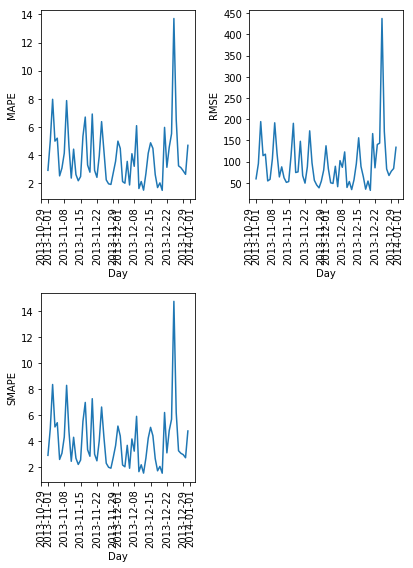

In [19]:
#del y_date[2]
# fig, (ax1,ax2) = plt.subplots(1,2, figsize =(8,6))
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
# ax1.xaxis.set_major_locator(mdates.DayLocator())
# ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
# ax2.xaxis.set_major_locator(mdates.DayLocator())
# ax1.plot(y_date,Mape_date)
# ax2.plot(y_date,rmse_date)
# fig.autofmt_xdate()
# ax1.set_xlabel('k')
# ax1.set_ylabel('cost')
date_time = pd.to_datetime(y_date)
DF = pd.DataFrame()
DF['Mape_date'] = Mape_date
DF = DF.set_index(date_time)

DF1 = pd.DataFrame()
DF1['rmse_date'] = rmse_date
DF1 = DF1.set_index(date_time)

DF2 = pd.DataFrame()
DF2['SMape_date'] = SMape_date
DF2 = DF2.set_index(date_time)
fig, ax1 = plt.subplots(2,2, figsize =(6,8))
fig.subplots_adjust(bottom=0.3,wspace = 0.3)
error = ["MAPE","RMSE","SMAPE",""]
cnt = 0
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
    plt.xlabel("Day")
    plt.ylabel(error[cnt])
    cnt += 1
ax1[0,0].plot(DF)
ax1[0,1].plot(DF1)
ax1[1,0].plot(DF2)
fig.tight_layout()
fig.delaxes(ax1[1,1])

In [20]:
from statistics import mean
print("Mean RMSE = {}, Mean Mape = {}, Mean SMAPE = {}".format(mean(rmse_date),mean(Mape_date),mean(SMape_date)))

Mean RMSE = 95.7840020908349, Mean Mape = 3.8993994183151455, Mean SMAPE = 3.9605417223007984


In [21]:
fig.savefig(base_path+"/plot/rf+bk=8-month.png")

In [22]:
actual_predicted = aggregate_df.where((aggregate_df.date==date(2013,11,29))).select("label","prediction").toPandas()
actual_predicted.head()

,label,prediction
0,1673.318,1732.670862
1,1770.985,1698.225485
2,2698.482,2699.455642
3,1620.043,1636.150595
4,1242.961,1286.330933


Text(0, 0.5, 'Load (Kw/h)')

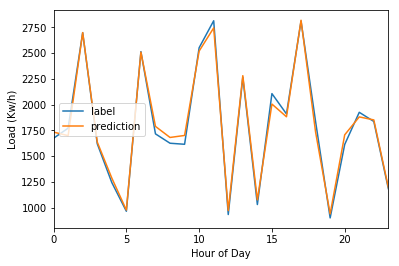

In [23]:
ax = actual_predicted.plot()
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Load (Kw/h)")

In [121]:
ax.get_figure().savefig(base_path+"/plot/rf+bk=8_predVSact29-11-month.png")

In [100]:
y_date[54]

datetime.date(2013, 12, 25)